In [1]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 경로 설정

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 분류 수 설정

In [3]:
NUM_CLASSES = 18

# 학습데이터 불러오기

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# 모델구축

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 64)                2752      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 18)                594       
                                                                 
Total params: 5,426
Trainable params: 5,426
Non-trainable params: 0
_________________________________________________________________


In [9]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 훈련

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/66 [..............................] - ETA: 8s - loss: 2.8876 - accuracy: 0.0703

2022-07-02 20:40:49.598551: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz



Epoch 00001: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
66/66 [==============================] - 0s 2ms/step - loss: 2.3901 - accuracy: 0.2812 - val_loss: 1.6612 - val_accuracy: 0.4935
Epoch 2/1000
 1/66 [..............................] - ETA: 0s - loss: 1.9007 - accuracy: 0.3828
Epoch 00002: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
66/66 [==============================] - 0s 976us/step - loss: 1.3379 - accuracy: 0.5865 - val_loss: 0.7095 - val_accuracy: 0.9071
Epoch 3/1000
 1/66 [..............................] - ETA: 0s - loss: 0.9092 - accuracy: 0.7422
Epoch 00003: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
66/66 [==============================] - 0s 992us/step - loss: 0.7777 - accuracy: 0.7564 - val_loss: 0.3281 - val_accuracy: 0.9852
Epoch 4/1000
 1/66 [..............................] - ETA: 0s - loss: 0.6081 - accuracy: 0.8359
Epoch 00004: saving model to model/keypoint_classifier/keypoint_classifier.hdf5


In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

22/22 [==============================] - 0s 368us/step - loss: 0.0090 - accuracy: 0.9971


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[5.7866357e-20 3.2050057e-12 6.6682684e-13 2.0373704e-11 2.4482767e-09
 3.8852629e-11 7.7335557e-17 6.8301124e-06 1.0589414e-07 8.5356542e-06
 2.6992568e-15 5.6732964e-23 2.0074377e-18 9.9998415e-01 9.2042168e-10
 2.9979327e-07 4.2258892e-16 1.8898336e-16]
13


# 시각화(confusion_matrix)

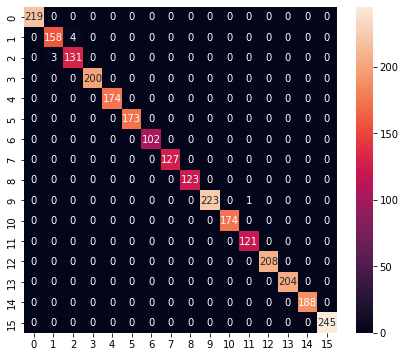

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       219
           1       0.98      0.98      0.98       162
           2       0.97      0.98      0.97       134
           3       1.00      1.00      1.00       200
           4       1.00      1.00      1.00       174
           5       1.00      1.00      1.00       173
           6       1.00      1.00      1.00       102
           7       1.00      1.00      1.00       127
           8       1.00      1.00      1.00       123
           9       1.00      1.00      1.00       224
          10       1.00      1.00      1.00       174
          11       0.99      1.00      1.00       121
          12       1.00      1.00      1.00       208
          13       1.00      1.00      1.00       204
          14       1.00      1.00      1.00       188
          15       1.00      1.00      1.00       245

    accuracy                           1.00      2778
   m

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite용 모델로 변환

In [16]:
# 추론 전용 모델로 저장
model.save(model_save_path, include_optimizer=False)

In [17]:
# 모델변환(양자화)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/yl/3qq35jrn65z0p93ls3scx5s80000gn/T/tmpf5dfaniz/assets


2022-07-02 20:40:58.125335: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-07-02 20:40:58.515445: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-07-02 20:40:58.515456: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-07-02 20:40:58.515634: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/yl/3qq35jrn65z0p93ls3scx5s80000gn/T/tmpf5dfaniz
2022-07-02 20:40:58.516313: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-07-02 20:40:58.516317: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /var/folders/yl/3qq35jrn65z0p93ls3scx5s80000gn/T/tmpf5dfaniz
2022-07-02 20:40:58.519001: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2022-07-02 20:40

9520

# 추론 테스트

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Initialized TensorFlow Lite runtime.


In [19]:
# 입출력 텐서 얻기
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# 추론 실시
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 121 µs, sys: 173 µs, total: 294 µs
Wall time: 175 µs


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.0380935e-20 2.8114839e-12 6.4579993e-13 1.5845658e-11 1.9272191e-09
 3.3849010e-11 6.3583501e-17 6.4679343e-06 1.0008688e-07 8.0249856e-06
 2.3442361e-15 4.2221240e-23 1.8294129e-18 9.9998510e-01 7.9038459e-10
 2.9646904e-07 3.6723738e-16 1.5407979e-16]
13
